# Image classification

In [1]:
import torch
from torch import Generator

# Set the random seed for reproducibility
random_state = 42

In [2]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

Using device: mps


## Preprocessing

In [3]:
import os
from data import train_val_split

base_dir = './data/train'
train_dir = './data/preprocessed/train'
val_dir = './data/preprocessed/val'

val_ratio = 0.2

if not os.path.exists(train_dir) and not os.path.exists(val_dir):
    train_val_split(base_dir, train_dir, val_dir, val_ratio, random_state) 

    print("Saved train data to:", train_dir)
    print("Saved validation data to:", val_dir)
else:
    print("Train and validation directories already exist.")

Train and validation directories already exist.


## Data

In [4]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from data import sample_dataset

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_ds = ImageFolder(train_dir, transform=train_transform)
val_ds = ImageFolder(val_dir, transform=val_transform)

# downsample the dataset
sample_ratio = 0.25
sampled_train_ds = sample_dataset(train_ds, sample_ratio, seed=random_state)
sampled_val_ds = sample_dataset(val_ds, sample_ratio, seed=random_state)

num_classes = len(train_ds.classes)

print(f"Number of training samples: {len(sampled_train_ds)}")
print(f"Number of validation samples: {len(sampled_val_ds)}")

batch_size = 256
num_workers = 0

# setup data loaders
train_dl = DataLoader(sampled_train_ds,
                      batch_size=batch_size,
                      num_workers=num_workers,
                      shuffle=True,
                      generator=Generator().manual_seed(random_state))

val_dl = DataLoader(sampled_val_ds,
                    batch_size=batch_size,
                    num_workers=num_workers, 
                    shuffle=False)

Number of training samples: 17602
Number of validation samples: 4400


Sample image shape: torch.Size([3, 64, 64])
Sample label: 0


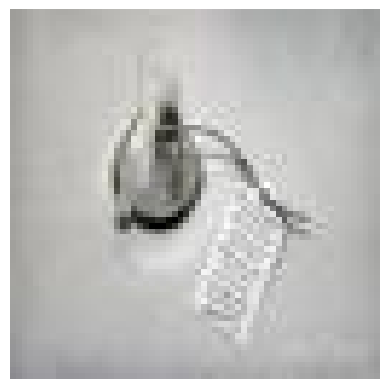

In [5]:
from utils import show_image

sample_img, sample_label = train_ds[0]

print(f"Sample image shape: {sample_img.size()}")
print(f"Sample label: {sample_label}")

show_image(sample_img)

## Model

In [6]:
from models import BasicNet

model = BasicNet(num_classes=num_classes)

## Training

In [ ]:
from training import Trainer
import torch.optim as optim

optimizer = optim.Adam(model.to(device).parameters(), lr=1e-3, weight_decay=1e-5)

trainer = Trainer(model, train_dl, val_dl, optimizer, device=device)
trainer.train(num_epochs=10)

Epoch 1/10 (validation): 100%|██████████| 18/18 [00:03<00:00,  5.22it/s]


Epoch 1/10: Train Loss: 3.5194, Val Loss: 3.2008, Avg Class Accuracy: 0.1653


Epoch 2/10 (validation): 100%|██████████| 18/18 [00:03<00:00,  5.31it/s]


Epoch 2/10: Train Loss: 3.1127, Val Loss: 2.9467, Avg Class Accuracy: 0.2196


Epoch 3/10 (validation): 100%|██████████| 18/18 [00:03<00:00,  5.33it/s]


Epoch 3/10: Train Loss: 2.8664, Val Loss: 2.7668, Avg Class Accuracy: 0.2476


Epoch 4/10 (validation): 100%|██████████| 18/18 [00:03<00:00,  5.16it/s]


Epoch 4/10: Train Loss: 2.7160, Val Loss: 2.6703, Avg Class Accuracy: 0.2718


Epoch 5/10 (validation): 100%|██████████| 18/18 [00:03<00:00,  5.32it/s]


Epoch 5/10: Train Loss: 2.5901, Val Loss: 2.9365, Avg Class Accuracy: 0.2348


Epoch 6/10 (validation): 100%|██████████| 18/18 [00:03<00:00,  5.24it/s]


Epoch 6/10: Train Loss: 2.5164, Val Loss: 2.5153, Avg Class Accuracy: 0.3054


Epoch 7/10 (validation): 100%|██████████| 18/18 [00:03<00:00,  5.24it/s]


Epoch 7/10: Train Loss: 2.4322, Val Loss: 2.3872, Avg Class Accuracy: 0.3316


Epoch 8/10 (validation): 100%|██████████| 18/18 [00:03<00:00,  4.85it/s]


Epoch 8/10: Train Loss: 2.3819, Val Loss: 2.3938, Avg Class Accuracy: 0.3334


Epoch 9/10 (validation): 100%|██████████| 18/18 [00:04<00:00,  4.46it/s]


Epoch 9/10: Train Loss: 2.2996, Val Loss: 2.3435, Avg Class Accuracy: 0.3565


Epoch 10/10 (training):  33%|███▎      | 23/69 [00:03<00:07,  6.24it/s]